Dataset

In [3]:
import sys
sys.path.append("..")

from src import dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary

import optuna

In [4]:
df = dataset.process_metadata("clear_2018/clear_2018.csv")
df

,Unnamed: 0,user,ROI,sen2,cloud_per,cloud_coverage,sensing_time,year,path
0,55,ANDREA,point_0502,20180316T103021_20180316T103018_T33VWJ,0.0,cloud-free,20180316T103021,2018,clear_2018\point_0502\20180316T103021_20180316...
1,70,ANDREA,point_0511,20180404T092031_20180404T092028_T36VVP,0.0,cloud-free,20180404T092031,2018,clear_2018\point_0511\20180404T092031_20180404...
2,190,ANDREA,point_0564,20180204T112249_20180204T112254_T29TNE,0.0,cloud-free,20180204T112249,2018,clear_2018\point_0564\20180204T112249_20180204...
3,205,ANDREA,point_0573,20181220T051219_20181220T051613_T44RQS,0.0,cloud-free,20181220T051219,2018,clear_2018\point_0573\20181220T051219_20181220...
4,415,ANDREA,point_0839,20181215T074319_20181215T074319_T38RPV,0.0,cloud-free,20181215T074319,2018,clear_2018\point_0839\20181215T074319_20181215...
...,...,...,...,...,...,...,...,...,...
203,9940,WENDY,point_8417,20181222T082341_20181222T083220_T35PQP,0.0,cloud-free,20181222T082341,2018,clear_2018\point_8417\20181222T082341_20181222...
204,9960,CESAR,point_8945,20180705T100031_20180705T100508_T33TWL,0.0,cloud-free,20180705T100031,2018,clear_2018\point_8945\20180705T100031_20180705...
205,9980,WENDY,point_9976,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,20181217T055231,2018,clear_2018\point_9976\20181217T055231_20181217...
206,9985,WENDY,point_9980,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,20181217T055231,2018,clear_2018\point_9980\20181217T055231_20181217...


In [5]:
df_train = df.sample(frac=0.6)
df_test = df.loc[~df.index.isin(df_train.index)]

In [6]:
len(df_train), len(df_test)

(125, 83)

In [7]:
any(item in df_test.index for item in df_train.index)

False

In [8]:
ds_train = dataset.TiffDataset(df_train, 256, True)
len(ds_train)

125

45


Text(0.5, 1.0, 'L2A')

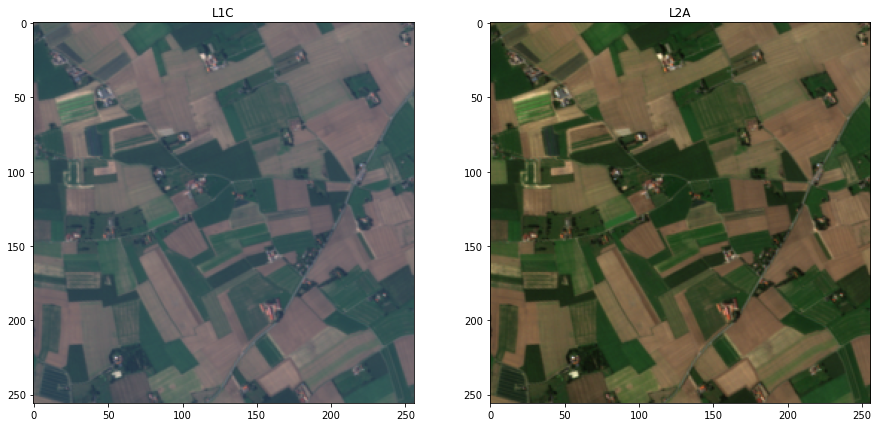

In [13]:
idx = np.random.randint(0,len(ds_train))
print(idx)
item = ds_train[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

Models

U-NET

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class UNET(nn.Module):
    def __init__(self, in_channels=13, out_channels=14, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="relu", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="relu", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [15]:
model = UNET()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          13,376
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
              ReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
              ReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
             ReLU-13          [-1, 512, 16, 16]               0
            Block-14          [-1, 512,

In [16]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = UNET()
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


FCNN

In [17]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        # Learnable layers
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=14, kernel_size=5, padding=2)


    def forward(self, x):
        # x.size() = (N, 13, W, W) 
        x = F.relu(self.conv1(x)) 
        # x.size() = (N, 32, W, W) 
        x = F.relu(self.conv2(x))
        # x.size() = (N, 64, W, W)  
        x = F.relu(self.conv3(x))
        # x.size() = (N, 32, W, W)
        x = self.conv4(x)
        # x.size() = (N, 14, W, W)
        return x

In [18]:
model = FCNN()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           3,776
            Conv2d-2         [-1, 64, 256, 256]          18,496
            Conv2d-3         [-1, 32, 256, 256]          18,464
            Conv2d-4         [-1, 14, 256, 256]          11,214
Total params: 51,950
Trainable params: 51,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.25
Forward/backward pass size (MB): 71.00
Params size (MB): 0.20
Estimated Total Size (MB): 74.45
----------------------------------------------------------------


In [19]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = FCNN()
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


Hyperparameter Tunning

[I 2022-05-01 12:31:32,935] A new study created in memory with name: no-name-572d8a97-6ed9-46ea-9447-510232e9a244
100%|██████████| 15/15 [22:00<00:00, 88.01s/it]


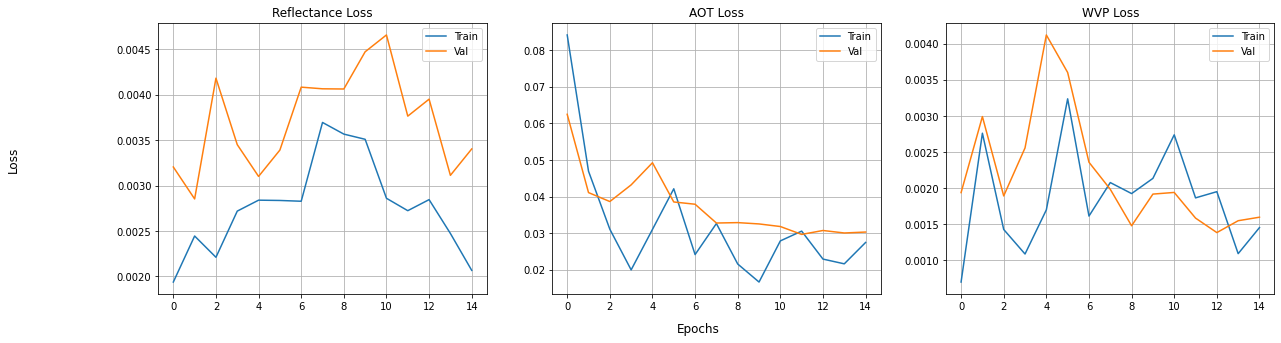

[I 2022-05-01 12:53:33,593] Trial 0 finished with value: 0.034536659717559814 and parameters: {'alpha': 0.9833615873309761, 'beta': 0.8144676883730725, 'lr': 0.00021785544480198846}. Best is trial 0 with value: 0.034536659717559814.
100%|██████████| 15/15 [20:19<00:00, 81.27s/it]


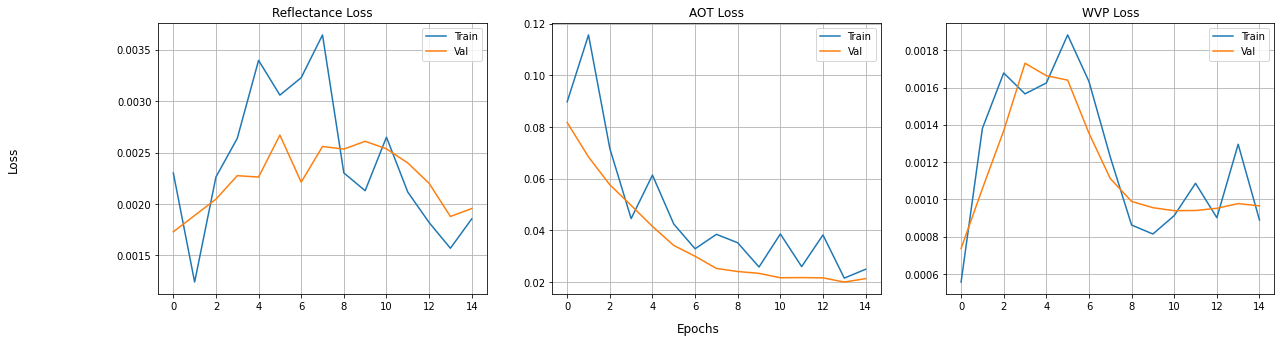

[I 2022-05-01 13:13:53,223] Trial 1 finished with value: 0.02165423333644867 and parameters: {'alpha': 0.8897067610052237, 'beta': 0.7449880521442858, 'lr': 6.44718791273496e-05}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [22:36<00:00, 90.42s/it]


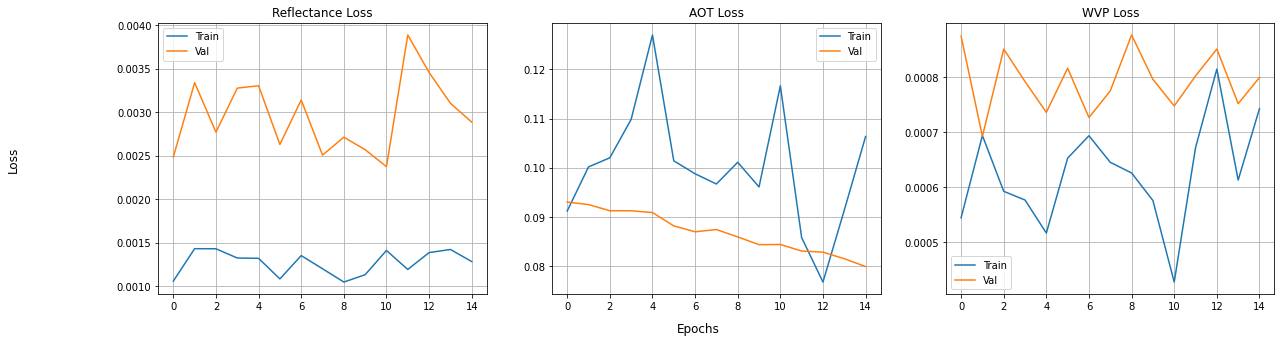

[I 2022-05-01 13:36:30,133] Trial 2 finished with value: 0.0308283232152462 and parameters: {'alpha': 0.3436420438539881, 'beta': 0.582921853879179, 'lr': 4.593341683364451e-06}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [23:37<00:00, 94.52s/it]


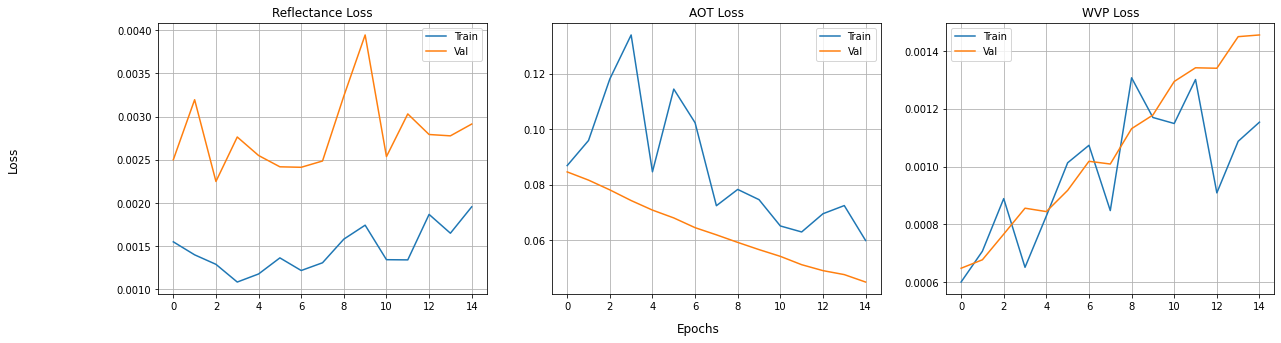

[I 2022-05-01 14:00:08,668] Trial 3 finished with value: 0.04638778790831566 and parameters: {'alpha': 0.9432357278616231, 'beta': 0.8162460689899212, 'lr': 1.7384102804468875e-05}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [23:25<00:00, 93.69s/it] 


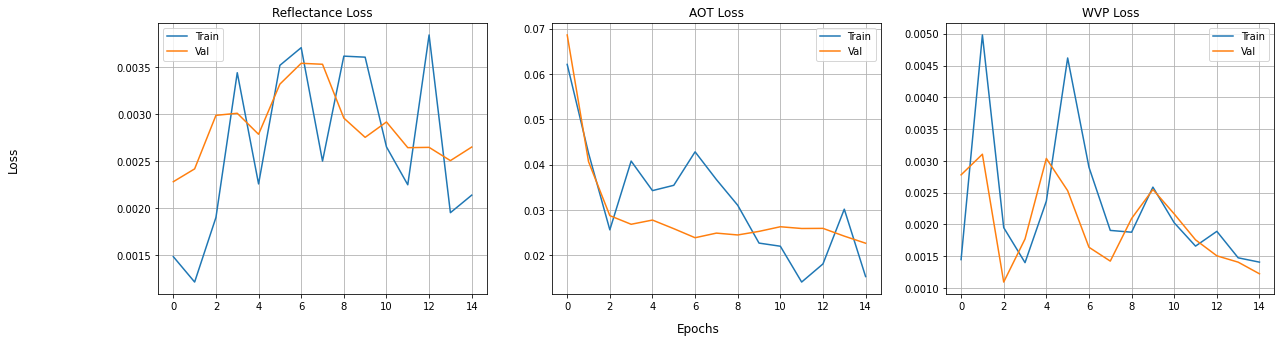

[I 2022-05-01 14:23:34,624] Trial 4 finished with value: 0.025825301185250282 and parameters: {'alpha': 0.9873050675655272, 'beta': 0.6517322323356765, 'lr': 0.00022282802086799437}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [20:56<00:00, 83.76s/it]


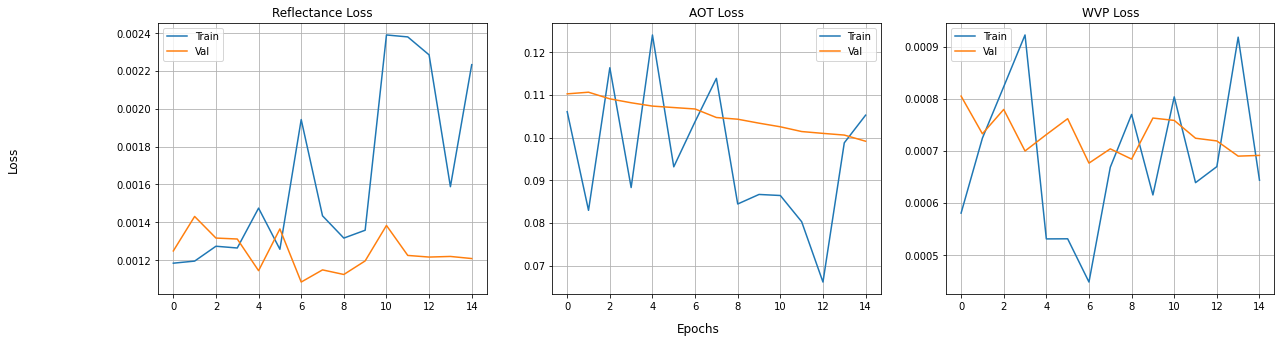

[I 2022-05-01 14:44:32,090] Trial 5 finished with value: 0.05712912976741791 and parameters: {'alpha': 0.5578401116245513, 'beta': 0.8992609988757885, 'lr': 3.4841944765726585e-06}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [19:27<00:00, 77.85s/it]


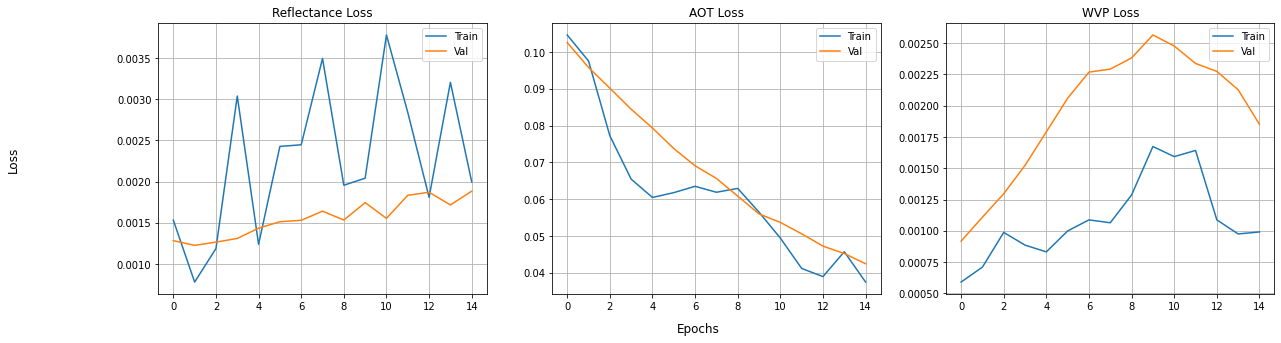

[I 2022-05-01 15:04:00,785] Trial 6 finished with value: 0.021798191592097282 and parameters: {'alpha': 0.4525748247912246, 'beta': 0.3784390364386171, 'lr': 3.0018448863056942e-05}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [22:57<00:00, 91.83s/it]


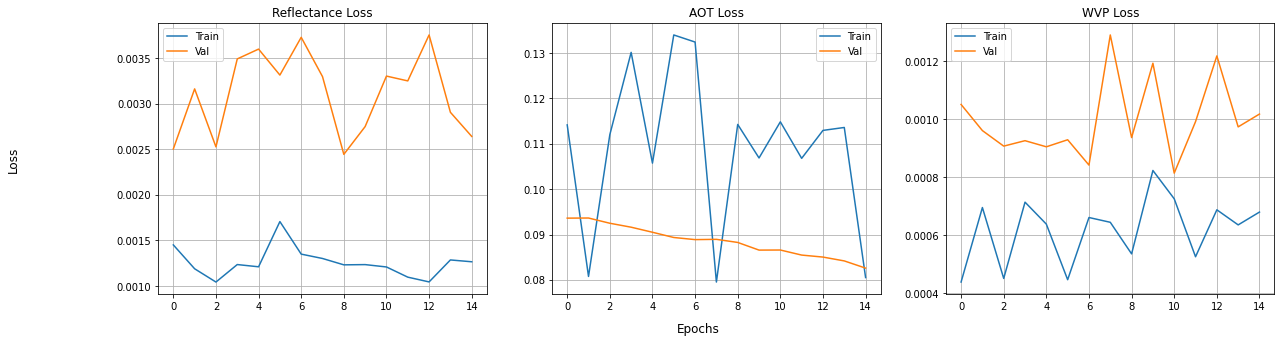

[I 2022-05-01 15:26:58,757] Trial 7 finished with value: 0.0838722512125969 and parameters: {'alpha': 0.9731021757159752, 'beta': 0.8386944890201877, 'lr': 3.4847079905614476e-06}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [19:47<00:00, 79.18s/it]


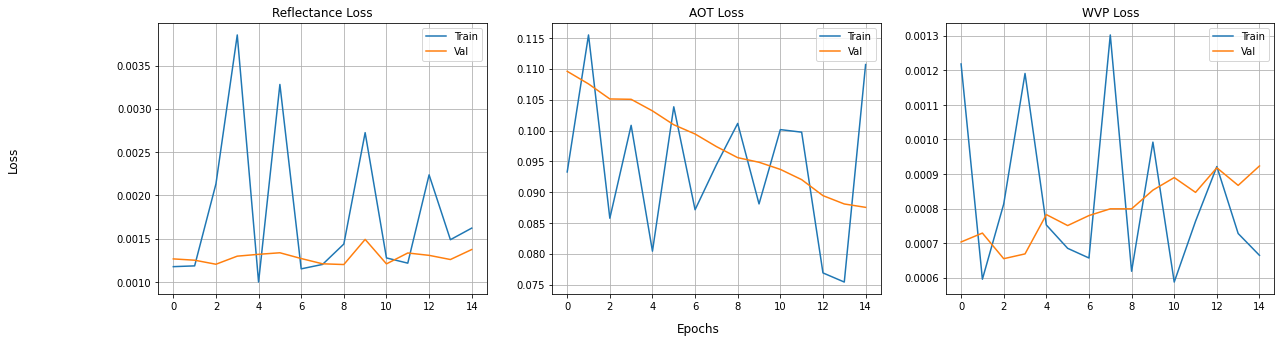

[I 2022-05-01 15:46:47,062] Trial 8 finished with value: 0.04813589155673981 and parameters: {'alpha': 0.5244231325828679, 'beta': 0.9265517466399384, 'lr': 7.3352508548326864e-06}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [19:15<00:00, 77.05s/it]


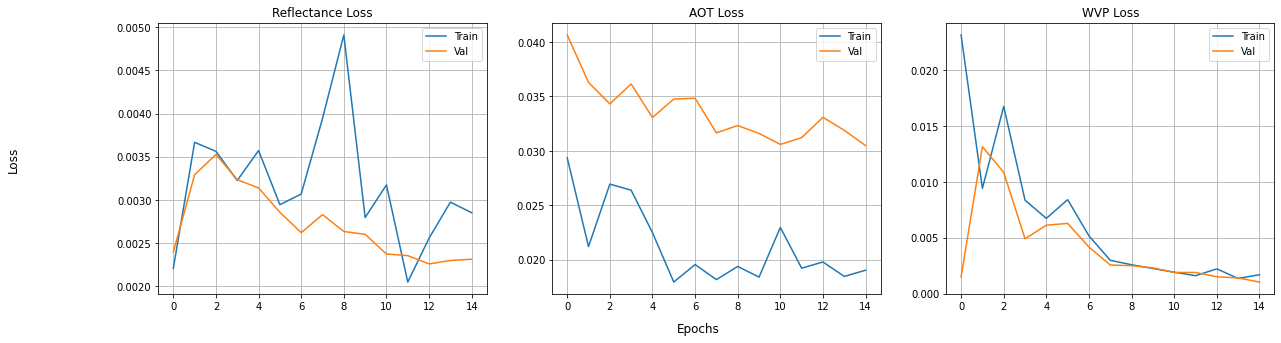

[I 2022-05-01 16:06:03,380] Trial 9 finished with value: 0.030111661180853844 and parameters: {'alpha': 0.8890958645292203, 'beta': 0.6546900671737176, 'lr': 0.0007908032064710727}. Best is trial 1 with value: 0.02165423333644867.
100%|██████████| 15/15 [20:36<00:00, 82.45s/it]


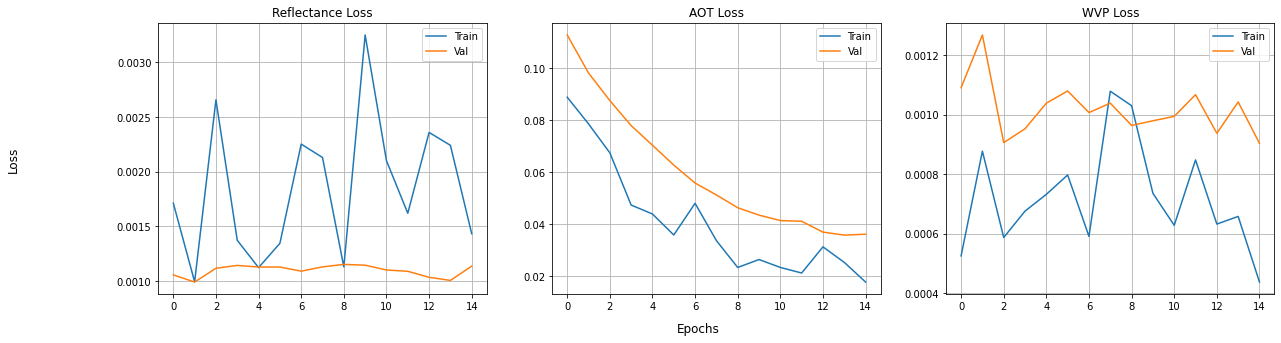

[I 2022-05-01 16:26:40,956] Trial 10 finished with value: 0.002207482233643532 and parameters: {'alpha': 0.027308927781284187, 'beta': 0.09128392405195557, 'lr': 9.860161598739531e-05}. Best is trial 10 with value: 0.002207482233643532.
100%|██████████| 15/15 [21:25<00:00, 85.67s/it]


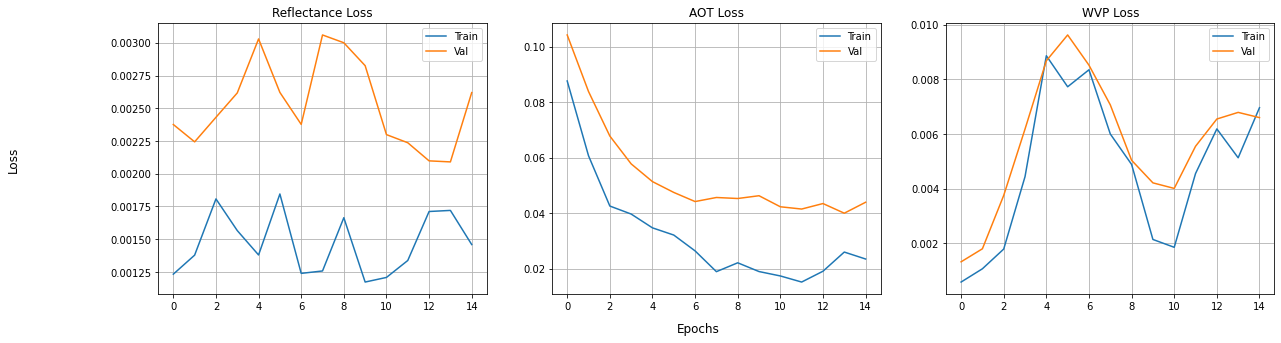

[I 2022-05-01 16:48:06,985] Trial 11 finished with value: 0.005824285559356213 and parameters: {'alpha': 0.07183680474041543, 'beta': 0.007101652552533325, 'lr': 0.0001117014714278886}. Best is trial 10 with value: 0.002207482233643532.
100%|██████████| 15/15 [17:51<00:00, 71.47s/it]


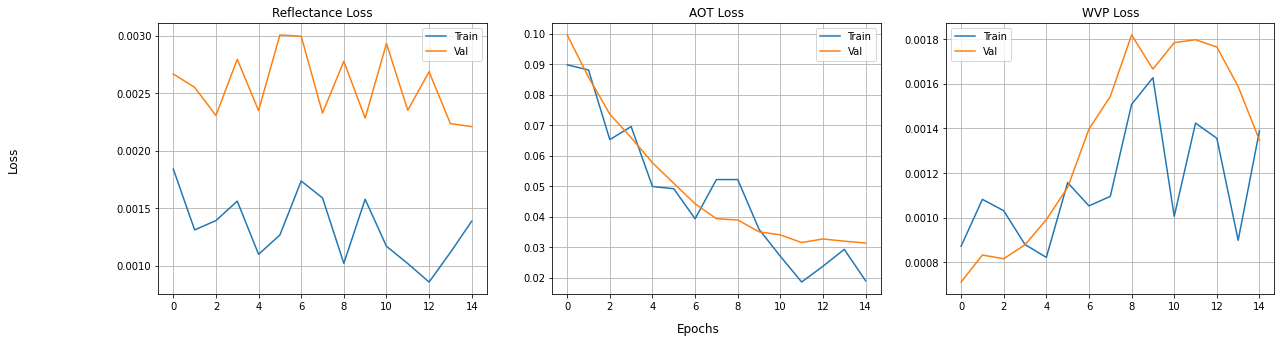

[I 2022-05-01 17:05:59,405] Trial 12 finished with value: 0.0026588812470436096 and parameters: {'alpha': 0.014222489217563195, 'beta': 0.002987467128798618, 'lr': 0.00011521387838148834}. Best is trial 10 with value: 0.002207482233643532.
100%|██████████| 15/15 [18:04<00:00, 72.32s/it]


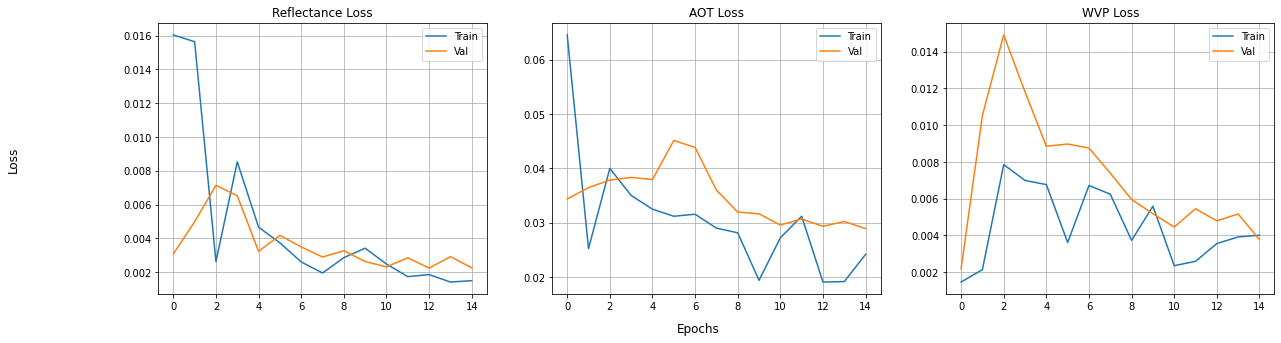

[I 2022-05-01 17:24:04,776] Trial 13 finished with value: 0.0031385510228574276 and parameters: {'alpha': 0.027319512540569448, 'beta': 0.022765638352428508, 'lr': 0.000963331203740232}. Best is trial 10 with value: 0.002207482233643532.
100%|██████████| 15/15 [18:57<00:00, 75.86s/it]


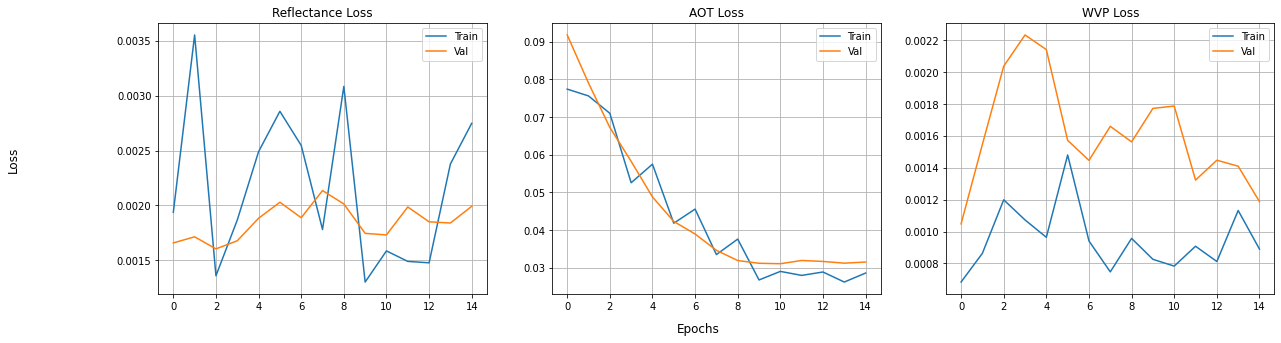

[I 2022-05-01 17:43:03,332] Trial 14 finished with value: 0.008401202969253063 and parameters: {'alpha': 0.19446529689930703, 'beta': 0.24410532076110186, 'lr': 7.478329030022824e-05}. Best is trial 10 with value: 0.002207482233643532.


In [26]:
trial_loss_train = []
trial_loss_val = []


def objective(trial):

    params = {
                'alpha': trial.suggest_float('alpha', 0, 1),
                'beta': trial.suggest_float('beta', 0, 1),
                "lr": trial.suggest_loguniform('lr', 1e-6, 1e-3)
                }

    # initialize our model
    model = FCNN()

    #If we want to load some model weights:

    model.load_state_dict(torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['state_dict'])

    # initialize loss function and optimizer
    lossFunc = MSELoss()
    opt = Adam(model.parameters(), lr=params['lr'])

    # initialize a dictionary to store training history
    H = {"train_loss": [], "val_loss": []}

    # select number of epochs
    num_epochs = 15

    batch_size = 50
    
    window = 256

    df_training = df_train.sample(frac=0.7)
    df_val = df_train.loc[~df_train.index.isin(df_training.index)]

    trainDS = dataset.TiffDataset(df_training, window, True)
    valDS = dataset.TiffDataset(df_val, window, True)

    trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

    # calculate steps per epoch for training and test set
    trainSteps = len(trainLoader)
    valSteps = len(valLoader)

    # loop over epochs
    train_metrics = []
    val_metrics = []
    alpha = params['alpha']
    beta = params['beta']

    for e in tqdm(range(num_epochs)):
        # set the model in training mode
        model.train()

        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0

        # loop over the training set
        for sample in trainLoader:
            # send the input to the device
            x = sample['sl1c']
            y = sample['sl2a']

            # perform a forward pass and calculate the training loss
            pred = model(x)
            train_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
            train_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
            train_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])

            loss = train_rad_loss + alpha*train_aot_loss + beta*train_wvp_loss
            if e == num_epochs-1:
                trial_loss_train.append(train_rad_loss)

            # first, zero out any previously accumulated gradients, then
            # perform backpropagation, and then update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            # add the loss to the total training loss so far
            totalTrainLoss += loss

        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()

            # loop over the validation set
            for sample in valLoader:
                # send the input to the device
                x = sample['sl1c']
                y = sample['sl2a']

                # make the predictions and calculate the validation loss
                pred = model(x)
                val_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
                val_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
                val_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])

                totalValLoss += val_rad_loss + alpha*val_aot_loss + beta*val_wvp_loss
                if e == num_epochs-1:
                    trial_loss_val.append(val_rad_loss)
                
        train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
        train_aot_loss_np = train_aot_loss.cpu().detach().numpy()
        train_wvp_loss_np = train_wvp_loss.cpu().detach().numpy()

        train_metrics.append((train_rad_loss_np, train_aot_loss_np, train_wvp_loss_np))

        val_rad_loss_np = val_rad_loss.cpu().detach().numpy()
        val_aot_loss_np = val_aot_loss.cpu().detach().numpy()
        val_wvp_loss_np = val_wvp_loss.cpu().detach().numpy()

        val_metrics.append((val_rad_loss_np, val_aot_loss_np, val_wvp_loss_np))
        
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgValLoss = totalValLoss / valSteps
        
    train_rad=[]
    train_aot=[]
    train_wvp=[]

    val_rad=[]
    val_aot=[]
    val_wvp=[]

    for i in range(num_epochs):
        train_rad.append(train_metrics[i][0])
        train_aot.append(train_metrics[i][1])
        train_wvp.append(train_metrics[i][2])

        val_rad.append(val_metrics[i][0])
        val_aot.append(val_metrics[i][1])
        val_wvp.append(val_metrics[i][2])

    train_plots = [train_rad, train_aot, train_wvp]
    val_plots = [val_rad, val_aot, val_wvp]
    titles = ['Reflectance Loss', 'AOT Loss', 'WVP Loss']

    fig, ax = plt.subplots(1,3,figsize=(20,5))

    for i in range(3):
        ax[i].plot(train_plots[i], label='Train')
        ax[i].plot(val_plots[i], label='Val')
        ax[i].set_title(titles[i])
        ax[i].legend()
        ax[i].grid('True')
    

    fig.supxlabel('Epochs')
    fig.supylabel('Loss')
    plt.show()
    
    return totalValLoss

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=15)

In [27]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

alpha: 0.027308927781284187
beta: 0.09128392405195557
lr: 9.860161598739531e-05


In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
optuna.visualization.plot_param_importances(study)

We will optimize the total loss function, considering reflectance, AOT and WVP, but we will use the parameters that minimize the reflectance overall, even if the separate losses of AOT and WVP are not optimal. We can check this with the following plot. 

In [31]:
import plotly.graph_objects as go

num_trials = len(study.trials)
val_ref = []
alpha = []
beta = []

for i in range(num_trials):
    val_ref.append(trial_loss_val[i].detach().cpu().numpy())
    alpha.append(study.trials[i].params['alpha'])
    beta.append(study.trials[i].params['beta'])


X = np.array(val_ref)
Y = np.array(alpha)
Z = np.array(beta)

fig = go.Figure(data=[go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(color=X, colorscale='Viridis'))])

fig.update_layout(scene = dict(
                    xaxis_title='Reflectance Loss',
                    yaxis_title='alpha',
                    zaxis_title='beta'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

Train

In [56]:
# initialize our model
model = FCNN()

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['params']['lr'])

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 10


In [57]:
batch_size = 50

df_training = df_train.sample(frac=0.7)
df_val = df_train.loc[~df_train.index.isin(df_training.index)]

window = 256

trainDS = dataset.TiffDataset(df_training.append(df_training).append(df_training).append(df_training).append(df_training).append(df_training), window, True)
valDS = dataset.TiffDataset(df_val.append(df_val).append(df_val).append(df_val).append(df_val).append(df_val), window, True)

trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

# calculate steps per epoch for training and test set
trainSteps = len(trainLoader)
valSteps = len(valLoader)

In [58]:
# loop over epochs
train_metrics = []
val_metrics = []
alpha = best_trial.params['alpha']#torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['alpha']
beta = best_trial.params['beta'] #torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['beta']

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for sample in trainLoader:
		# send the input to the device
		x = sample['sl1c']
		y = sample['sl2a']

		# perform a forward pass and calculate the training loss
		pred = model(x)
		train_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
		train_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
		train_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
		loss = train_rad_loss + alpha*train_aot_loss + beta*train_wvp_loss

		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for sample in valLoader:
			# send the input to the device
			x = sample['sl1c']
			y = sample['sl2a']

			# make the predictions and calculate the validation loss
			pred = model(x)
			val_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
			val_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
			val_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
			totalValLoss += val_rad_loss + alpha*val_aot_loss + beta*val_wvp_loss

			

	train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
	train_aot_loss_np = train_aot_loss.cpu().detach().numpy()
	train_wvp_loss_np = train_wvp_loss.cpu().detach().numpy()
	
	train_metrics.append((train_rad_loss_np, train_aot_loss_np, train_wvp_loss_np))

	val_rad_loss_np = val_rad_loss.cpu().detach().numpy()
	val_aot_loss_np = val_aot_loss.cpu().detach().numpy()
	val_wvp_loss_np = val_wvp_loss.cpu().detach().numpy()

	val_metrics.append((val_rad_loss_np, val_aot_loss_np, val_wvp_loss_np))
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print(pd.DataFrame({'rad': [np.around(train_rad_loss_np, decimals=4), np.around(val_rad_loss_np, decimals=4)], 
                        'aot': [np.around(train_aot_loss_np, decimals=4), np.around(val_aot_loss_np, decimals=4)], 
                        'wvp': [np.around(train_wvp_loss_np, decimals=4), np.around(val_wvp_loss_np, decimals=4)]}, ['train', 'val']))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] training the network...


 10%|█         | 1/10 [11:26<1:42:55, 686.16s/it]

[INFO] EPOCH: 1/10
          rad     aot     wvp
train  0.0214  0.0825  0.0341
val    0.0142  0.0341  0.0448


 20%|██        | 2/10 [20:59<1:26:59, 652.44s/it]

[INFO] EPOCH: 2/10
          rad     aot     wvp
train  0.0067  0.0268  0.0185
val    0.0090  0.0331  0.0197


 30%|███       | 3/10 [30:23<1:12:59, 625.71s/it]

[INFO] EPOCH: 3/10
          rad     aot     wvp
train  0.0045  0.0603  0.0278
val    0.0043  0.0217  0.0182


 40%|████      | 4/10 [39:23<59:59, 599.96s/it]  

[INFO] EPOCH: 4/10
          rad     aot     wvp
train  0.0039  0.0392  0.0174
val    0.0036  0.0306  0.0190


 50%|█████     | 5/10 [47:25<47:02, 564.54s/it]

[INFO] EPOCH: 5/10
          rad     aot     wvp
train  0.0032  0.0326  0.0123
val    0.0030  0.0287  0.0114


 60%|██████    | 6/10 [55:35<36:09, 542.27s/it]

[INFO] EPOCH: 6/10
          rad     aot     wvp
train  0.0028  0.0313  0.0127
val    0.0021  0.0236  0.0149


 70%|███████   | 7/10 [1:03:10<25:48, 516.13s/it]

[INFO] EPOCH: 7/10
          rad     aot     wvp
train  0.0045  0.0355  0.0062
val    0.0024  0.0321  0.0118


 80%|████████  | 8/10 [1:10:43<16:34, 497.13s/it]

[INFO] EPOCH: 8/10
          rad     aot     wvp
train  0.0018  0.0360  0.0090
val    0.0023  0.0235  0.0044


 90%|█████████ | 9/10 [1:18:15<08:03, 483.65s/it]

[INFO] EPOCH: 9/10
          rad     aot     wvp
train  0.0026  0.0362  0.0248
val    0.0025  0.0211  0.0084


100%|██████████| 10/10 [1:25:48<00:00, 514.87s/it]

[INFO] EPOCH: 10/10
          rad     aot     wvp
train  0.0019  0.0207  0.0109
val    0.0023  0.0252  0.0133
[INFO] total time taken to train the model: 5148.72s


Evaluate predictions

Text(0.02, 0.5, 'Loss')

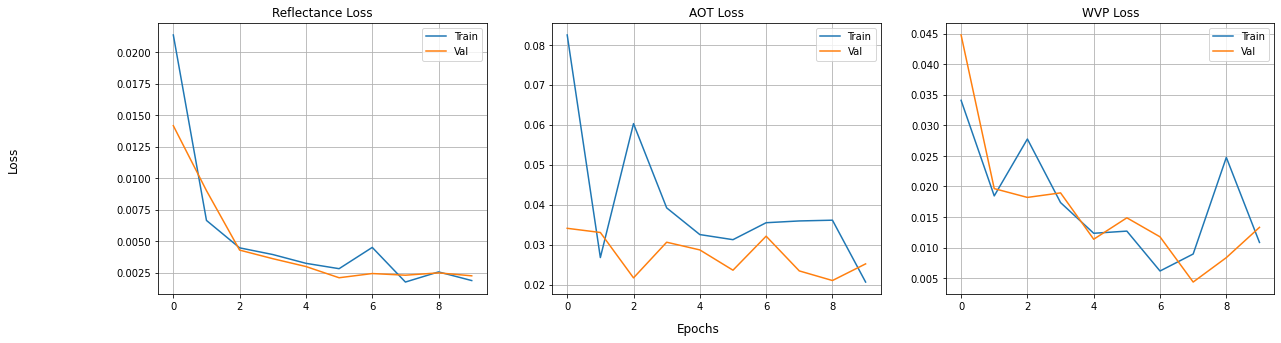

In [59]:
train_rad=[]
train_aot=[]
train_wvp=[]

val_rad=[]
val_aot=[]
val_wvp=[]
for i in range(num_epochs):
    train_rad.append(train_metrics[i][0])
    train_aot.append(train_metrics[i][1])
    train_wvp.append(train_metrics[i][2])

    val_rad.append(val_metrics[i][0])
    val_aot.append(val_metrics[i][1])
    val_wvp.append(val_metrics[i][2])

train_plots = [train_rad, train_aot, train_wvp]
val_plots = [val_rad, val_aot, val_wvp]
titles = ['Reflectance Loss', 'AOT Loss', 'WVP Loss']

fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(3):
    ax[i].plot(train_plots[i], label='Train')
    ax[i].plot(val_plots[i], label='Val')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid('True')

fig.supxlabel('Epochs')
fig.supylabel('Loss')

Global metrics

RMSE and PSNR for each band averaged for the complete test set:

In [60]:
test = dataset.TiffDataset(df_test, 256, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()

BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']
rmse_total = 0
psnr_total = 0

for j in range(len(test)):
    item = test[j]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    rmse_pred = []
    psnr_pred = []
    for i in range(len(preds[0])):
        
        #We need to convert aot and wvp to their original values in order to evaluate the performance
        if i == 12:
            rmse = torch.sqrt(loss(preds[0][i]*dataset.aot_max, item['sl2a'][i]*dataset.aot_max))
            psnr = 20*torch.log10(torch.max(preds[0][i]*dataset.aot_max)/rmse)
        if i == 13:
            rmse = torch.sqrt(loss(preds[0][i]*dataset.wvp_max, item['sl2a'][i]*dataset.wvp_max))
            psnr = 20*torch.log10(torch.max(preds[0][i]*dataset.wvp_max)/rmse)
        else:
            rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
            psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

        rmse_pred.append(rmse.detach().numpy())
        psnr_pred.append(psnr.detach().numpy())
    
    rmse_total += np.array(rmse_pred)
    psnr_total += np.array(psnr_pred)

RMSE = rmse_total / len(test)
PSNR = psnr_total / len(test)

pd.DataFrame(np.concatenate((RMSE,PSNR)).reshape(2,14), methods, BANDS_L2A)

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AOT,WVP
RMSE,0.044519,0.044223,0.036338,0.037854,0.036432,0.039432,0.041074,0.048482,0.040892,0.044789,0.052755,0.046154,0.154423,0.477695
PSNR,18.248198,19.131216,21.360649,22.830235,23.075903,23.295494,23.602846,22.306786,24.065680,23.276999,18.212111,18.457050,13.283987,13.050233


Individual metrics (choose id)

RMSE and PSNR for an individual sample of the test set:

In [61]:
test = dataset.TiffDataset(df_test, 256, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()
rmse_pred = []
psnr_pred = []
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']


for i in range(len(preds[0])):
    #We need to convert aot and wvp to their original values in order to evaluate the performance
    if i == 12:
        rmse = torch.sqrt(loss(preds[0][i]*dataset.aot_max, item['sl2a'][i]*dataset.aot_max))
        psnr = 20*torch.log10(torch.max(preds[0][i]*dataset.aot_max)/rmse)
    if i == 13:
        rmse = torch.sqrt(loss(preds[0][i]*dataset.wvp_max, item['sl2a'][i]*dataset.wvp_max))
        psnr = 20*torch.log10(torch.max(preds[0][i]*dataset.wvp_max)/rmse)
    else:
        rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
        psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

    rmse_pred.append(rmse.detach().numpy())
    psnr_pred.append(psnr.detach().numpy())

print('Id:', idx)
pd.DataFrame(np.concatenate((np.array(rmse_pred),np.array(psnr_pred))).reshape(2,14), methods, BANDS_L2A)

Id: 72


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AOT,WVP
RMSE,0.060081,0.042748,0.033736,0.046577,0.033003,0.034285,0.034139,0.050957,0.028769,0.023930,0.082908,0.109260,0.076672,0.112159
PSNR,12.672638,16.984413,21.456387,21.683338,25.036339,23.921032,23.998472,20.847948,25.985859,27.148306,17.901356,15.229978,18.996252,18.183968


The following plot displays the ratio between **prediction - real value** of a series of pixels (100) from the test set images and for each band separately.

Text(0, 0.5, 'Y_pred / Y_real')

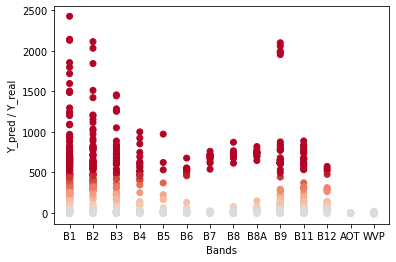

In [110]:
import matplotlib.colors as colors

boxplot = []
samples = 100

for sample in range(len(test)):
    test = dataset.TiffDataset(df_test, 256, False)
    #id = np.random.randint(0, len(test))
    item = test[sample]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    for sample in range(samples):
        idx = np.random.randint(0, preds.shape[2])
        idy = np.random.randint(0, preds.shape[3])
        for band in range(preds.shape[1]):
                boxplot.append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']

plt.scatter(BANDS_L2A*samples*len(test), boxplot, c=boxplot, cmap='coolwarm', norm=colors.Normalize(-500,500))
plt.xlabel('Bands')
plt.ylabel('Y_pred / Y_real')

68


Text(0, 0.5, 'Y_pred / Y_real')

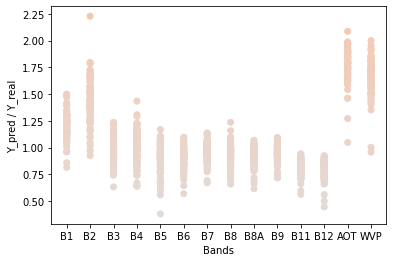

In [104]:
boxplot_2 = []
samples = 100

test = dataset.TiffDataset(df_test, 256, False)
id = np.random.randint(0, len(test))
print(id)
item = test[id]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

for sample in range(samples):
    idx = np.random.randint(0, preds.shape[2])
    idy = np.random.randint(0, preds.shape[3])
    for band in range(preds.shape[1]):
            boxplot_2.append(preds[0][band][idx,idy].cpu().detach().numpy()/item['sl2a'][band][idx,idy].cpu().detach().numpy())
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']

plt.scatter(BANDS_L2A*samples, boxplot_2, c=boxplot_2, cmap='coolwarm', norm=colors.Normalize(-10,10))
plt.xlabel('Bands')
plt.ylabel('Y_pred / Y_real')

Plot predictions

Text(0.5, 1.0, 'Pred')

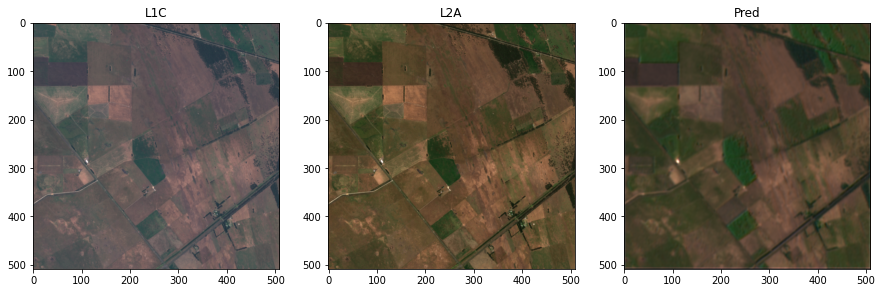

In [85]:
test = dataset.TiffDataset(df_test, 256, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")

ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")
ax[2].imshow(predic)
ax[2].set_title("Pred")

Finally, we can save the trained model weights and optimized hyperparameters to use them in the future

In [27]:
model_save = {'state_dict': model.state_dict(), 'params': best_trial.params}

#torch.save(model_save, 'saved_models/fcnn_e20_batch50_model_save.pth') 

Load previously saved model weights

In [16]:
model.load_state_dict(torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['state_dict'])

<All keys matched successfully>

In [17]:
torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['params']

{'alpha': 0.9075653154732716,
 'beta': 0.5301136408744364,
 'lr': 0.000829354460589568}

In [29]:
#fer boxplot de la figura de slack en test: eje x bandes, 
#fer sampling de 100 punts random de la imatge de test i plotejar el ratio entre la imatge real i la predicció